# Building a model for salary prediction

In [1]:
import pandas as pd
from scipy import stats
from scipy.stats import normaltest
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kruskal
import seaborn as sns
from collections import OrderedDict
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


data = pd.read_csv('cy2019-md.csv', low_memory=False)

df = pd.DataFrame(data)

df.loc[(df['subtitle'].str.contains('360231-UMBC|360295-UMBC', na=False)), 'location'] = "Baltimore County"
df.loc[(df['subtitle'].str.contains('UMCP', na=False)), 'location'] = "Prince Georges County"
df.loc[(df['subtitle'].str.contains('360221-UMB|360291-UMB', na=False)), 'location'] = "Baltimore City"
df.loc[(df['subtitle'].str.contains('UMES', na=False)), 'location'] = "Somerset County"
df.loc[(df['subtitle'].str.contains('UMGC', na=False)), 'location'] = "Prince Georges County"

df.loc[(df['subtitle'].str.contains('360231-UMBC|360295-UMBC', na=False)), 'School'] = "UMBC"
df.loc[(df['subtitle'].str.contains('UMCP', na=False)), 'School'] = "UMCP"
df.loc[(df['subtitle'].str.contains('360221-UMB|360291-UMB', na=False)), 'School'] = "UMB"
df.loc[(df['subtitle'].str.contains('UMES', na=False)), 'School'] = "UMES"
df.loc[(df['subtitle'].str.contains('UMGC', na=False)), 'School'] = "UMGC"

cut_points = [-1, 10000, 20000, 30000, 40000, 
              50000, 60000, 70000, 80000, 90000, 100000, 10000000]
label_names = ["0-10000","10001-20000","20001-30000","30001-40000","40001-50000",
              "50001-60000","60001-70000","70001-80000","80001-90000","90001-100000", "100000+"]
df["income_categories"] = pd.cut(df["ytd_gross_earnings"],cut_points,labels=label_names)

UMBC = df[df['subtitle'].str.contains('360231-UMBC|360295-UMBC', na=False)]
UMCP = df[df['subtitle'].str.contains('UMCP', na=False)]
UMB = df[df['subtitle'].str.contains('360221-UMB|360291-UMB', na=False)]
UMGC = df[df['subtitle'].str.contains('UMGC', na=False)]
UMES = df[df['subtitle'].str.contains('UMES', na=False)]

universities = UMBC.append(UMCP).append(UMB).append(UMGC).append(UMES)
display(universities)

,first_name,middle_initial,last_name,suffix,system,agency,organization,subtitle,class_code,annual_salary,pay_rate,regular_earnings,overtime_earnings,other_earnings,ytd_gross_earnings,term_date,location,School,income_categories
123086,OLEG,NaN,FIRSIN,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1012,100000.0,A,104000,0,500,105000,NaN,Baltimore County,UMBC,100000+
123087,B,M,RABIN,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1212,141000.0,A,138000,0,500,138000,NaN,Baltimore County,UMBC,100000+
123088,MD TOUHIDUL,NaN,ISLAM,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1212,32000.0,A,0,0,10500,10000,NaN,Baltimore County,UMBC,0-10000
123089,RUCHITA,NaN,PARAB,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1111,0.0,H,0,0,5600,6000,2019-05-26T00:00:00Z,Baltimore County,UMBC,0-10000
123090,SURBHI,G,LIPKIN-MOORE,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1212,18000.0,A,1000,0,9000,10000,NaN,Baltimore County,UMBC,0-10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116289,IYAD ELDIN,M,ELFADIL,NaN,UM,360225,UNIVERSITY OF MARYLAND,360225-UMES,1111,0.0,H,1000,0,0,1000,NaN,Somerset County,UMES,0-10000
116290,AHMED,O,IBRAHIM,NaN,UM,360225,UNIVERSITY OF MARYLAND,360225-UMES,1111,0.0,H,0,0,0,0,2019-05-15T00:00:00Z,Somerset County,UMES,0-10000
116291,ZOE,C,JOHNSON,NaN,UM,360225,UNIVERSITY OF MARYLAND,360225-UMES,1212,15000.0,A,0,0,16800,17000,NaN,Somerset County,UMES,10001-20000
116292,SAWSAN,A,MOHAMED,NaN,UM,360225,UNIVERSITY OF MARYLAND,360225-UMES,1010,6000.0,A,6000,0,0,6000,NaN,Somerset County,UMES,0-10000


In [2]:
universities['location_id'] = universities['location'].map({'Baltimore County': 0, 'Prince Georges County': 1,  
                                                       'Baltimore City': 2, 'Somerset County': 3}).astype(int)

universities['school_id'] = universities['School'].map({'UMBC': 0, 'UMCP': 1,  
                                                       'UMB': 2, 'UMES': 3, 'UMGC': 4}).astype(int)

universities['class_code_id'] = universities['class_code'].map({1010: 0, 1012: 1, 1111: 2, 1212: 3, 9512: 4})

universities['income_categories_id'] = universities['income_categories'].map({"0-10000":1, "10001-20000":2,"20001-30000":3,
                                                                          "30001-40000":4,"40001-50000":5,
                                                                          "50001-60000":6,"60001-70000":7,
                                                                          "70001-80000":8,"80001-90000":9,
                                                                          "90001-100000":10, "100000+":11}).astype(int)

universities['pay_rate_id'] = universities['pay_rate'].map({'A': 0, 'H': 1}).astype(int)
universities

,first_name,middle_initial,last_name,suffix,system,agency,organization,subtitle,class_code,annual_salary,...,ytd_gross_earnings,term_date,location,School,income_categories,location_id,school_id,class_code_id,income_categories_id,pay_rate_id
123086,OLEG,NaN,FIRSIN,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1012,100000.0,...,105000,NaN,Baltimore County,UMBC,100000+,0,0,1,11,0
123087,B,M,RABIN,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1212,141000.0,...,138000,NaN,Baltimore County,UMBC,100000+,0,0,3,11,0
123088,MD TOUHIDUL,NaN,ISLAM,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1212,32000.0,...,10000,NaN,Baltimore County,UMBC,0-10000,0,0,3,1,0
123089,RUCHITA,NaN,PARAB,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1111,0.0,...,6000,2019-05-26T00:00:00Z,Baltimore County,UMBC,0-10000,0,0,2,1,1
123090,SURBHI,G,LIPKIN-MOORE,NaN,UM,360231,UNIVERSITY OF MARYLAND,360231-UMBC,1212,18000.0,...,10000,NaN,Baltimore County,UMBC,0-10000,0,0,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116289,IYAD ELDIN,M,ELFADIL,NaN,UM,360225,UNIVERSITY OF MARYLAND,360225-UMES,1111,0.0,...,1000,NaN,Somerset County,UMES,0-10000,3,3,2,1,1
116290,AHMED,O,IBRAHIM,NaN,UM,360225,UNIVERSITY OF MARYLAND,360225-UMES,1111,0.0,...,0,2019-05-15T00:00:00Z,Somerset County,UMES,0-10000,3,3,2,1,1
116291,ZOE,C,JOHNSON,NaN,UM,360225,UNIVERSITY OF MARYLAND,360225-UMES,1212,15000.0,...,17000,NaN,Somerset County,UMES,10001-20000,3,3,3,2,0
116292,SAWSAN,A,MOHAMED,NaN,UM,360225,UNIVERSITY OF MARYLAND,360225-UMES,1010,6000.0,...,6000,NaN,Somerset County,UMES,0-10000,3,3,0,1,0


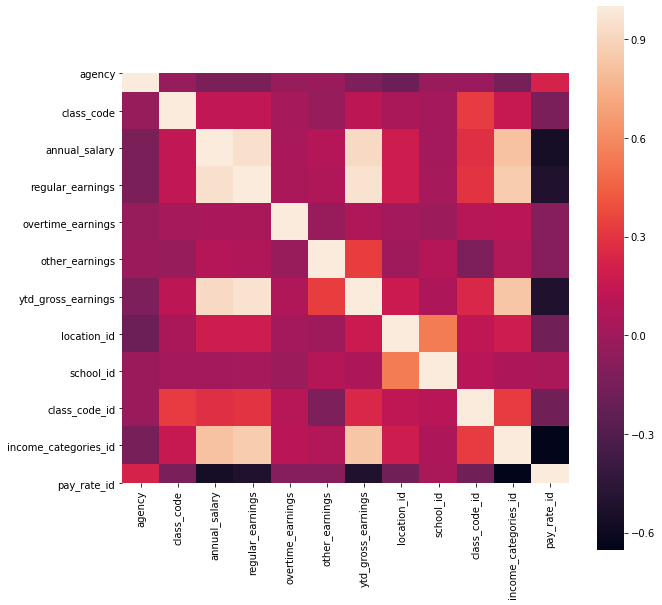

In [3]:
corr = universities.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, vmax=1, square=True)

The heat map shows there are some sort of relations for income and location, income and school, income and class code.

In [4]:
X = universities[['location_id', 'school_id', 'class_code_id', 'pay_rate_id']]
Y = universities['income_categories_id']
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
classifier = SVC(gamma='auto')
classifier.fit(X_train, Y_train)
score = classifier.score(x_test, y_test)
print(score)

0.5520873375874529


In [6]:
def predict_salary(location_id, school_id, class_code_id, pay_rate_id):
    predict_data = OrderedDict([('location_id',location_id),('school_id', school_id),('class_code_id', class_code_id),('pay_rate_id', pay_rate_id)])
    predict_data = pd.Series(predict_data).values.reshape(1,-1)
    return classifier.predict(predict_data)[0]

In [8]:
df = pd.DataFrame([{'location':'location id','Baltimore County': 0, 'Prince Georges County': 1,  
                                                       'Baltimore City': 2, 'Somerset County': 3}])
df2 = pd.DataFrame([{'School':'School id','UMBC (Baltimore County)': 0, 'UMCP (Prince Georges County)': 1, 
                     'UMB (Baltimore City)': 2, 'UMES (Somerset County)': 3, 'UMGC (Prince Georges County)': 4}])
df3 = pd.DataFrame([{'class code':'class code id',1010: 0, 1012: 1, 1111: 2, 1212: 3, 9512: 4}])
df4 = pd.DataFrame([{'income categories ':'income categories id',"0-10000":1, "10001-20000":2,"20001-30000":3,
                                                                          "30001-40000":4,"40001-50000":5,
                                                                          "50001-60000":6,"60001-70000":7,
                                                                          "70001-80000":8,"80001-90000":9,
                                                                           "90001-100000":10, "100000+":11}])
df5 = pd.DataFrame([{'Pay rate':'Pay rate id','A': 0, 'H': 1}]) 
display(df)
display(df2)
display(df3)
display(df5)
display(df4)

location_id = input("Enter location id : ")
school_id = input("Enter school id id : ")
class_code_id = input("Enter class code id : ")
pay_rate_id = input("Enter pay rate id : ")
print('Prediction result: income category id = ', predict_salary(location_id, school_id, class_code_id,pay_rate_id))



,location,Baltimore County,Prince Georges County,Baltimore City,Somerset County
0,location id,0,1,2,3


,School,UMBC (Baltimore County),UMCP (Prince Georges County),UMB (Baltimore City),UMES (Somerset County),UMGC (Prince Georges County)
0,School id,0,1,2,3,4


,class code,1010,1012,1111,1212,9512
0,class code id,0,1,2,3,4


,Pay rate,A,H
0,Pay rate id,0,1


,income categories,0-10000,10001-20000,20001-30000,30001-40000,40001-50000,50001-60000,60001-70000,70001-80000,80001-90000,90001-100000,100000+
0,income categories id,1,2,3,4,5,6,7,8,9,10,11


Enter location id : 3
Enter school id id : 3
Enter class code id : 3
Enter pay rate id : 0
Prediction result: income category id =  5
